In this notebook, I will use the same VAE architecture as before but set the latent variable $z$ to be $\gamma \sim N(0, 30)$ and have the model predict allele age from $X_l$.  

In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Layer, Lambda, Multiply, Add

# Commonly used modules
import numpy as np
import os
import sys

# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm
import statsmodels.api as sm
from statsmodels.distributions.empirical_distribution import ECDF

# change matplotlib fonts
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.sans-serif"] = "Arial"

In [12]:
df1 = pd.read_csv("https://raw.githubusercontent.com/VivaswatS/selCoefEst/main/traindata/trip-2021-07-28.csv")

dat = df1.to_numpy()
gamma = np.unique(dat[:,1])
idx = [np.where(dat[:,1] == gamma[i]) for i in np.arange(len(gamma))]

In [21]:
dat[:,(0,2)]

array([[8.800e-03, 3.810e+02],
       [7.800e-03, 5.590e+02],
       [1.200e-03, 3.690e+02],
       ...,
       [9.876e-01, 2.631e+03],
       [3.060e-02, 7.050e+02],
       [8.898e-01, 1.044e+03]])

In [48]:
from sklearn.model_selection import train_test_split
# 85/15 split - creating a training data set of only (Xl, al) - no gamma
temp = train_test_split(np.log(dat[:,(0,2)]), test_size=0.15, random_state=42)

train_data = temp[0][:,0]
train_labs = temp[0][:,1]
test_data = temp[1][:,0]
test_labs = temp[1][:,1]

In [16]:
# this helps makes our output less verbose but still shows progress
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

In [85]:
intermediate_dim = 1024
latent_dim = 1
batch_size = 512
epsilon_std = 1.0
sigma2sq = np.sqrt(20.0).astype('float32')

def mse(y_true, y_pred):
    return keras.backend.sum(keras.metrics.mean_squared_error(y_true, y_pred), axis=-1)

# when z (i.e., \gamma) ~ N(\mu_2=0, \sigma_2) - can only do one latent dimension
class KLDivergenceLayer(Layer):
    """ Identity transform layer that adds KL divergence to the final model loss.
    """
    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)

    def call(self, inputs):
        mu, log_var = inputs
        kl_batch = keras.backend.log(sigma2sq) - log_var + .5 * (keras.backend.exp(log_var) + keras.backend.square(mu))/sigma2sq - .5

        self.add_loss(keras.backend.mean(kl_batch), inputs=inputs)
        return inputs
# class KLDivergenceLayer(Layer):
#     """ Identity transform layer that adds KL divergence
#     to the final model loss.
#     """
#     def __init__(self, *args, **kwargs):
#         self.is_placeholder = True
#         super(KLDivergenceLayer, self).__init__(*args, **kwargs)

#     def call(self, inputs):
#         mu, log_var = inputs
#         kl_batch = - .5 * keras.backend.sum(1 + log_var -
#                                             keras.backend.square(mu) -
#                                             keras.backend.exp(log_var), axis=-1)

#         self.add_loss(keras.backend.mean(kl_batch), inputs=inputs)
#         return inputs

# input is 1 dim - Xl
x = keras.Input(shape=(1,))
h = Dense(512, activation='relu')(x)
h = Dense(intermediate_dim, activation='relu')(h)

gamma_mu = Dense(latent_dim)(h)
gamma_log_var = Dense(latent_dim)(h)

gamma_mu, gamma_log_var = KLDivergenceLayer()([gamma_mu, gamma_log_var])
gamma_sigma = Lambda(lambda t: keras.backend.exp(.5*t))(gamma_log_var)

eps = keras.Input(tensor=keras.backend.random_normal(stddev=epsilon_std, shape=(keras.backend.shape(x)[0], latent_dim)))
gamma_eps = Multiply()([gamma_sigma, eps])
gamma = Add()([gamma_mu, gamma_eps])

# only need 1 output dim - allele age
decoder = keras.Sequential([
    Dense(512, input_dim=latent_dim, activation='relu'), 
    Dense(intermediate_dim, input_dim=512, activation='relu'), 
    Dense(1, activation='relu')
])

x_pred = decoder(gamma)
# symbolic representation
encoder = keras.Model(x, outputs=[gamma_mu, gamma_sigma])

In [86]:
vae = keras.Model(inputs=[x, eps], outputs=x_pred)
vae.compile(optimizer='rmsprop', loss=mse)

history = vae.fit((train_data, np.random.randn(train_data.shape[0],latent_dim)), train_labs, epochs=5000, verbose=0, validation_split=0.1, shuffle=True,
                    validation_data=((test_data, np.random.randn(test_data.shape[0],latent_dim)), test_labs), callbacks=[early_stop, PrintDot()])

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch


..................................................................

In [88]:
gamma_preds = encoder.predict(test_data)
preds_mean_vae = np.exp(np.ravel(decoder.predict(gamma_preds[0])))

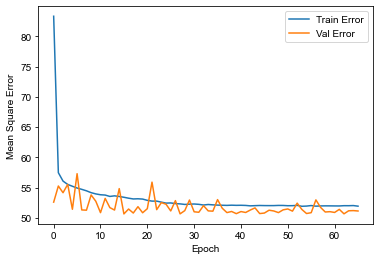

In [89]:
def plot_history():
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error')
    plt.plot(hist['epoch'], hist['loss'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_loss'], label = 'Val Error')
    plt.legend()

plot_history()

(array([[   0.,    0.,    0.,    0., 7500.,    0.,    0.,    0.,    0.,
            0.],
        [   0.,    0.,    0.,    0., 7500.,    0.,    0.,    0.,    0.,
            0.],
        [   0.,    0.,    0., 2031., 5469.,    0.,    0.,    0.,    0.,
            0.],
        [   0.,    0.,    0., 1499., 6001.,    0.,    0.,    0.,    0.,
            0.],
        [   0.,    0.,    0.,    0., 7500.,    0.,    0.,    0.,    0.,
            0.],
        [1447.,  654.,  877.,  768.,  787.,  834.,  634.,  688.,  262.,
          549.],
        [   0.,    0.,    0.,    0., 7500.,    0.,    0.,    0.,    0.,
            0.],
        [   0.,    0.,    0.,    0., 7500.,    0.,    0.,    0.,    0.,
            0.],
        [   0.,    0.,    0.,    0., 7500.,    0.,    0.,    0.,    0.,
            0.],
        [   0.,    0.,    0.,    0., 7500.,    0.,    0.,    0.,    0.,
            0.],
        [   0.,    0.,    0.,    0., 7500.,    0.,    0.,    0.,    0.,
            0.],
        [   0.,    0.

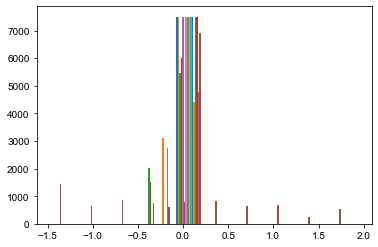

In [80]:
plt.hist(gamma_preds[0])

Text(40000, 2500, 'Intercept = 5288.98')

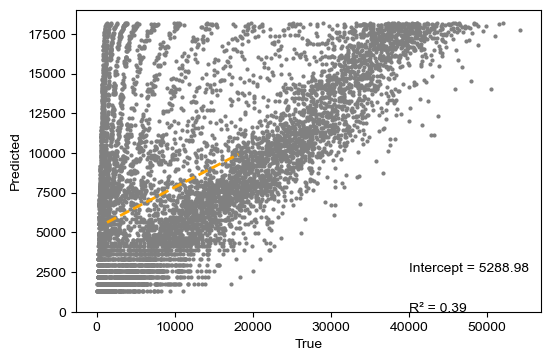

In [90]:
plt.figure(dpi=100)
plt.ylabel('Predicted')
plt.xlabel('True')
plt.plot(np.exp(np.ravel(test_labs)), preds_mean_vae, 'o', color='grey', markersize=2)
plt.ylim(0)
res = sm.OLS(preds_mean_vae, sm.add_constant(np.exp(np.ravel(test_labs)))).fit()
muhat, betahat = res.params
x_ = np.linspace(np.min(preds_mean_vae), np.max(preds_mean_vae), 20)
plt.plot(x_, muhat + betahat * x_, color="orange", linestyle='--', linewidth=2)
plt.text(40000, 10, "R² = {:.2f}".format(res.rsquared))
plt.text(40000, 2500, "Intercept = {:.2f}".format(muhat))